In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

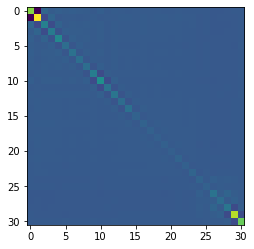

In [4]:
plt.imshow(syscov)

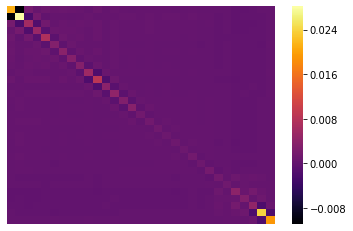

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
# plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [6]:
np.min(np.abs(syscov)), np.max(np.abs(syscov)) #checking non-negatives in the diagonal

(1.695011341e-07, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [7]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.05 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 1000 matrix 

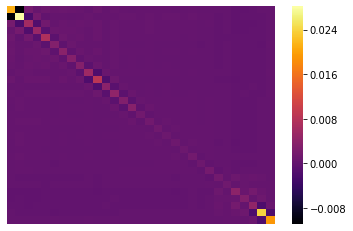

In [8]:
val, vec = np.linalg.eigh(syscov)
D = np.diag(val)
new = (vec+0.1) @ (D) @ (vec+0.1).T
sns.heatmap(pd.DataFrame(syscov), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

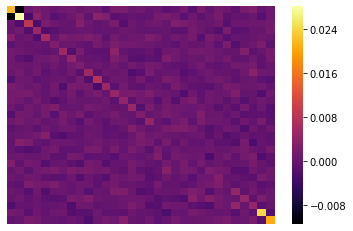

In [9]:
sns.heatmap(pd.DataFrame(covset[10]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [10]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


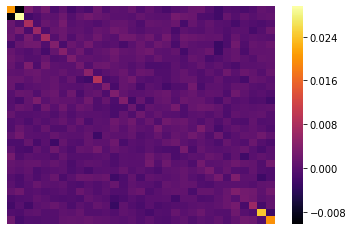

In [11]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [12]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)               

In [13]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test))
#                 callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/500
25/25 [==============================] - 0s 6ms/step - loss: 8.4995e-04 - val_loss: 6.9673e-05
Epoch 2/500
25/25 [==============================] - 0s 2ms/step - loss: 1.9707e-04 - val_loss: 2.1049e-05
Epoch 3/500
25/25 [==============================] - 0s 2ms/step - loss: 9.9573e-05 - val_loss: 1.0638e-05
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 6.4106e-05 - val_loss: 6.6578e-06
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 4.7514e-05 - val_loss: 4.6625e-06
Epoch 6/500
25/25 [==============================] - 0s 2ms/step - loss: 3.6250e-05 - val_loss: 3.5858e-06
Epoch 7/500
25/25 [==============================] - 0s 2ms/step - loss: 2.9068e-05 - val_loss: 2.8965e-06
Epoch 8/500
25/25 [==============================] - 0s 3ms/step - loss: 2.4806e-05 - val_loss: 2.4817e-06
Epoch 9/500
25/25 [==============================] - 0s 3ms/step - loss: 2.1003e-05 - val_loss: 2.1565e-06
Epoch 10/500
25/25 [=================

Epoch 77/500
25/25 [==============================] - 0s 2ms/step - loss: 1.5315e-06 - val_loss: 1.0326e-06
Epoch 78/500
25/25 [==============================] - 0s 2ms/step - loss: 1.5343e-06 - val_loss: 1.0346e-06
Epoch 79/500
25/25 [==============================] - 0s 2ms/step - loss: 1.5222e-06 - val_loss: 1.0337e-06
Epoch 80/500
25/25 [==============================] - 0s 2ms/step - loss: 1.4896e-06 - val_loss: 1.0322e-06
Epoch 81/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4966e-06 - val_loss: 1.0282e-06
Epoch 82/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4731e-06 - val_loss: 1.0361e-06
Epoch 83/500
25/25 [==============================] - 0s 2ms/step - loss: 1.4645e-06 - val_loss: 1.0274e-06
Epoch 84/500
25/25 [==============================] - 0s 2ms/step - loss: 1.4641e-06 - val_loss: 1.0307e-06
Epoch 85/500
25/25 [==============================] - 0s 2ms/step - loss: 1.4494e-06 - val_loss: 1.0302e-06
Epoch 86/500
25/25 [========

25/25 [==============================] - 0s 2ms/step - loss: 1.1029e-06 - val_loss: 1.0464e-06
Epoch 228/500
25/25 [==============================] - 0s 2ms/step - loss: 1.1069e-06 - val_loss: 1.0419e-06
Epoch 229/500
25/25 [==============================] - 0s 2ms/step - loss: 1.1025e-06 - val_loss: 1.0449e-06
Epoch 230/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1046e-06 - val_loss: 1.0483e-06
Epoch 231/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1045e-06 - val_loss: 1.0498e-06
Epoch 232/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1020e-06 - val_loss: 1.0423e-06
Epoch 233/500
25/25 [==============================] - 0s 2ms/step - loss: 1.1047e-06 - val_loss: 1.0446e-06
Epoch 234/500
25/25 [==============================] - 0s 2ms/step - loss: 1.1033e-06 - val_loss: 1.0449e-06
Epoch 235/500
25/25 [==============================] - 0s 2ms/step - loss: 1.1001e-06 - val_loss: 1.0402e-06
Epoch 236/500
25/25 [============

25/25 [==============================] - 0s 2ms/step - loss: 1.0706e-06 - val_loss: 1.0469e-06
Epoch 378/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0712e-06 - val_loss: 1.0494e-06
Epoch 379/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0689e-06 - val_loss: 1.0490e-06
Epoch 380/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0703e-06 - val_loss: 1.0406e-06
Epoch 381/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0683e-06 - val_loss: 1.0442e-06
Epoch 382/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0695e-06 - val_loss: 1.0394e-06
Epoch 383/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0696e-06 - val_loss: 1.0479e-06
Epoch 384/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0691e-06 - val_loss: 1.0473e-06
Epoch 385/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0714e-06 - val_loss: 1.0461e-06
Epoch 386/500
25/25 [============

(array([-0.0002,  0.    ,  0.0002,  0.0004,  0.0006,  0.0008,  0.001 ]),
 <a list of 7 Text major ticklabel objects>)

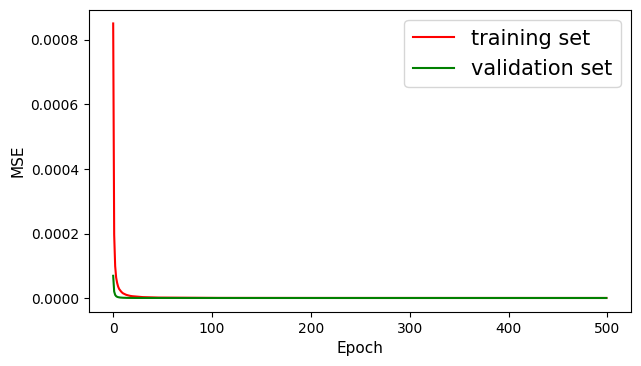

In [25]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [18]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

1.027429334499175e-06 1.0595216508590966e-06


In [19]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(200, 31)


(200, 961)


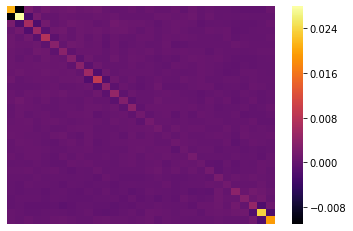

In [20]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


In [21]:
print(np.shape(decoded_imgs))

(200, 961)


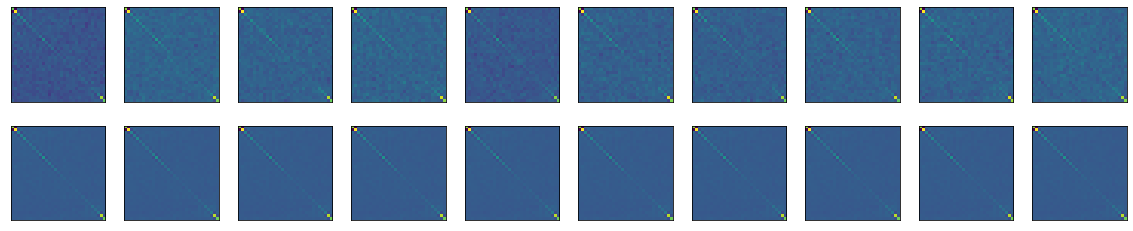

In [22]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

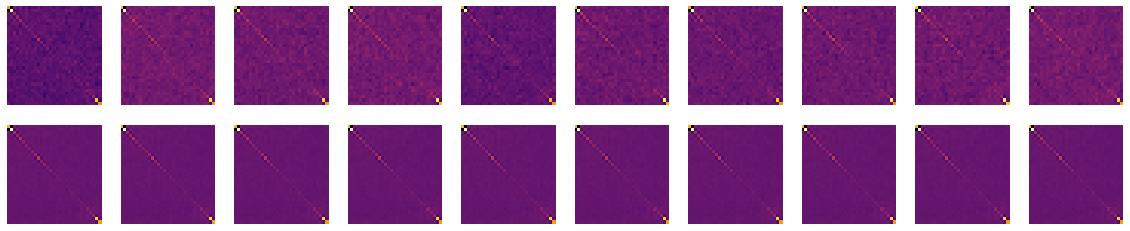

In [23]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
# plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

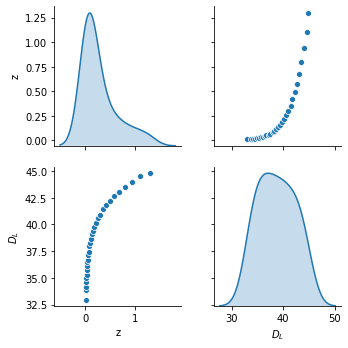

In [81]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
# print(data.head(31))
sns.pairplot(data, diag_kind="kde")
# plt.savefig("DistbinnedJLA.png")

In [82]:
shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

In [83]:
z = data[:,0]
dl = data[:,1:]

In [84]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [85]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)

In [86]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=20,
                                   restore_best_weights=True)]

In [87]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(50, activation='relu')(efirst)
    x = Dense(50, activation='relu')(x)
    x = Dense(30, activation='relu')(x)

    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 1
epochs = 300
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 50)                100       
_________________________________________________________________
dense_31 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_32 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_33 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 31        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
___________________________________________________

In [88]:
model_train = neural_model.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/300
24/24 [==============================] - 0s 4ms/step - loss: 1435.2206 - val_loss: 1727.5372
Epoch 2/300
24/24 [==============================] - 0s 1ms/step - loss: 1401.1906 - val_loss: 1672.9620
Epoch 3/300
24/24 [==============================] - 0s 1ms/step - loss: 1284.9467 - val_loss: 1480.8431
Epoch 4/300
24/24 [==============================] - 0s 1ms/step - loss: 870.5633 - val_loss: 885.6757
Epoch 5/300
24/24 [==============================] - 0s 1ms/step - loss: 231.5090 - val_loss: 173.7134
Epoch 6/300
24/24 [==============================] - 0s 1ms/step - loss: 99.3272 - val_loss: 169.9425
Epoch 7/300
24/24 [==============================] - 0s 1ms/step - loss: 68.9487 - val_loss: 132.4173
Epoch 8/300
24/24 [==============================] - 0s 1ms/step - loss: 57.8538 - val_loss: 116.9561
Epoch 9/300
24/24 [==============================] - 0s 1ms/step - loss: 50.9082 - val_loss: 96.4016
Epoch 10/300
24/24 [==============================] - 0s 1ms/step - loss

Epoch 82/300
24/24 [==============================] - 0s 1ms/step - loss: 1.5006 - val_loss: 0.7146
Epoch 83/300
24/24 [==============================] - 0s 1ms/step - loss: 0.9549 - val_loss: 0.3879
Epoch 84/300
24/24 [==============================] - 0s 1ms/step - loss: 1.2181 - val_loss: 0.5981
Epoch 85/300
24/24 [==============================] - 0s 1ms/step - loss: 0.8010 - val_loss: 0.6663
Epoch 86/300
24/24 [==============================] - 0s 1ms/step - loss: 1.0178 - val_loss: 0.6734
Epoch 87/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7807 - val_loss: 0.3436
Epoch 88/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7715 - val_loss: 0.4707
Epoch 89/300
24/24 [==============================] - 0s 1ms/step - loss: 0.8112 - val_loss: 0.7708
Epoch 90/300
24/24 [==============================] - 0s 1ms/step - loss: 0.8655 - val_loss: 0.6514
Epoch 91/300
24/24 [==============================] - 0s 1ms/step - loss: 0.8348 - val_loss: 0.4512


24/24 [==============================] - 0s 1ms/step - loss: 0.5109 - val_loss: 1.0783
Epoch 245/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5612 - val_loss: 0.0699
Epoch 246/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5164 - val_loss: 0.0053
Epoch 247/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1960 - val_loss: 0.0188
Epoch 248/300
24/24 [==============================] - 0s 993us/step - loss: 0.3465 - val_loss: 0.2078
Epoch 249/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4256 - val_loss: 0.1557
Epoch 250/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3468 - val_loss: 0.0568
Epoch 251/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2154 - val_loss: 0.0795
Epoch 252/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2404 - val_loss: 0.2819
Epoch 253/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3588 - val_loss: 0.8135
Ep

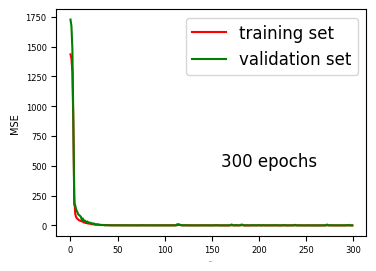

In [109]:
plt.figure(figsize=(4, 3), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE', fontsize=7)
plt.xlabel('Epoch', fontsize=1)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.text(160, 500, '300 epochs', fontsize=12)
# plt.title('FFNN', fontsize=8)
# plt.savefig("loss_dlbinnedJla_.png")

In [31]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet, np.min(model_train.history['loss']), np.min(model_train.history['val_loss'])

(0.338522810288569, 0.398973673582077, 0.11459769308567047)

In [32]:
# pred = neural_model.predict(z_test)
# pred

In [33]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z), 31)
ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranzz)
# pred_random

In [34]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [35]:
fake_encoded = np.zeros((1, 31))

In [36]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))


(1, 31)
(31,)
(200, 31)


In [37]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]

In [38]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake), np.shape(fake_encoded)

((1, 961), (1, 31))

In [39]:
# decoded_fake[0, :]

6.449336e-07

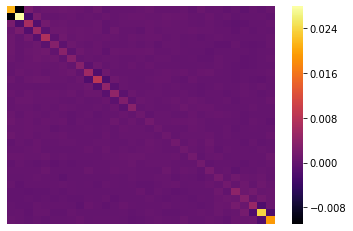

In [40]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
# plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

-0.01084098704 0.02815552265 0.00039265133851975654
-0.010946177 0.027955165 0.00039581588
-0.010968339 0.02798875 0.0003970579


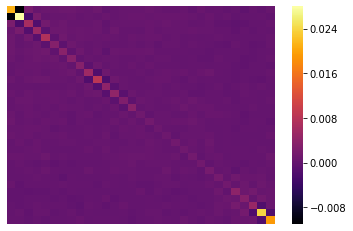

In [41]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal
print(np.min(clean_img[0,:]), np.max(clean_img[0,:]), np.mean(clean_img[0,:])) #checking non-negatives in the diagonal



In [42]:
# np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
# np.savetxt("fake_binned_JLA_COVdecodedclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [43]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
#             print(i,j, end=' ')
#             print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

465

In [44]:
# np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", header="#fake COV")

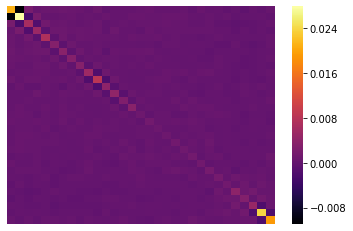

In [45]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [46]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)
# np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")

In [47]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
np.max(errors), np.max(fakeerrors)

(0.1677960745965173, 0.16719799)

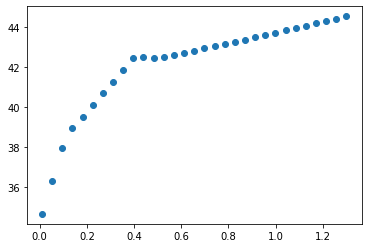

In [48]:
plt.scatter(ranz, pred_random)

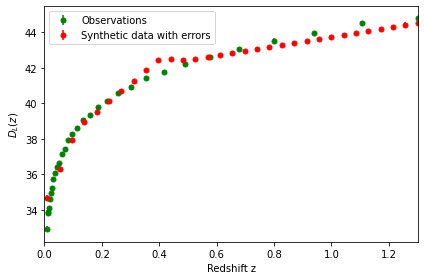

In [49]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
# plt.savefig('fake_vs_binned_jla.png', dpi=200)

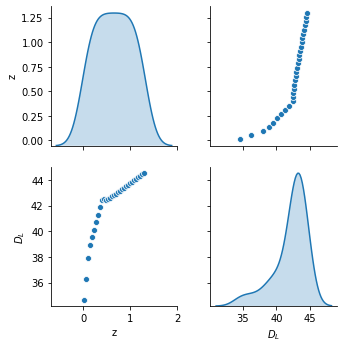

In [50]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
# plt.savefig('fake_binned_jla.png')

### NOW we use dropout as uncertainty estimator

In [51]:
from astroNN.nn.layers import MCDropout

In [52]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))
# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.2)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.2)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.2)(encoded2)
#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.2)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
# x2 = MCDropout(0.2)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               96200     
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 31)                3131      
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)               

In [53]:
batch_size = 4
# optimizer = Adam(lr=.005)
# optimizer = Adam(lr=0.0001)


autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test),
                    callbacks=callbacks)

Epoch 1/500
25/25 [==============================] - 0s 10ms/step - loss: 6.5650e-04 - val_loss: 2.3775e-04
Epoch 2/500
25/25 [==============================] - 0s 4ms/step - loss: 1.3801e-04 - val_loss: 9.8605e-05
Epoch 3/500
25/25 [==============================] - 0s 4ms/step - loss: 6.7102e-05 - val_loss: 6.2585e-05
Epoch 4/500
25/25 [==============================] - 0s 4ms/step - loss: 4.3282e-05 - val_loss: 4.4868e-05
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 3.2636e-05 - val_loss: 3.6634e-05
Epoch 6/500
25/25 [==============================] - 0s 6ms/step - loss: 2.4712e-05 - val_loss: 2.7712e-05
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 1.9854e-05 - val_loss: 2.2984e-05
Epoch 8/500
25/25 [==============================] - 0s 6ms/step - loss: 1.6690e-05 - val_loss: 2.0226e-05
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 1.4252e-05 - val_loss: 1.6581e-05
Epoch 10/500
25/25 [================

Epoch 77/500
25/25 [==============================] - 0s 5ms/step - loss: 1.2799e-06 - val_loss: 1.4186e-06
Epoch 78/500
25/25 [==============================] - 0s 5ms/step - loss: 1.2770e-06 - val_loss: 1.3947e-06
Epoch 79/500
25/25 [==============================] - 0s 5ms/step - loss: 1.2759e-06 - val_loss: 1.4156e-06
Epoch 80/500
25/25 [==============================] - 0s 5ms/step - loss: 1.2576e-06 - val_loss: 1.3853e-06
Epoch 81/500
25/25 [==============================] - 0s 5ms/step - loss: 1.2495e-06 - val_loss: 1.3863e-06
Epoch 82/500
25/25 [==============================] - 0s 5ms/step - loss: 1.2426e-06 - val_loss: 1.3598e-06
Epoch 83/500
25/25 [==============================] - 0s 5ms/step - loss: 1.2404e-06 - val_loss: 1.3841e-06
Epoch 84/500
25/25 [==============================] - 0s 5ms/step - loss: 1.2326e-06 - val_loss: 1.3484e-06
Epoch 85/500
25/25 [==============================] - 0s 4ms/step - loss: 1.2319e-06 - val_loss: 1.3344e-06
Epoch 86/500
25/25 [========

25/25 [==============================] - 0s 4ms/step - loss: 1.0642e-06 - val_loss: 1.0788e-06
Epoch 228/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0636e-06 - val_loss: 1.0834e-06
Epoch 229/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0678e-06 - val_loss: 1.0805e-06
Epoch 230/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0628e-06 - val_loss: 1.0772e-06
Epoch 231/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0623e-06 - val_loss: 1.0727e-06
Epoch 232/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0615e-06 - val_loss: 1.0759e-06
Epoch 233/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0607e-06 - val_loss: 1.0806e-06
Epoch 234/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0605e-06 - val_loss: 1.0786e-06
Epoch 235/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0612e-06 - val_loss: 1.0798e-06
Epoch 236/500
25/25 [============

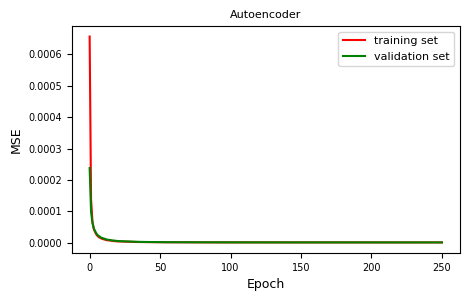

In [54]:
plt.figure(figsize=(5, 3), dpi=100)

plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=9)
plt.xlabel('Epoch', fontsize=9)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLAdropout.png', dpi=100)

In [55]:
encoder2 = tf.keras.Model(input_img2, encoded2)
# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [56]:
decoder2.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               3200      
_________________________________________________________________
MCDropout_4 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
_______________________________________________

In [57]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
print(np.shape(fake_encoded))
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0)
std_mc_dropout_dec = np.std(predictions_dec, axis=0)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(1, 31)


((1, 961), (1, 961))

In [58]:
np.mean(std_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(2.887152812892614e-05, (1, 961))

In [74]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.02)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.02)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.02)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.02)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 4
epochs = 400
input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                100       
_________________________________________________________________
MCDropout_9 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_10 (MCDropout)     (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_11 (MCDropout)     (None, 50)              

In [75]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test))

Epoch 1/400
6/6 [==============================] - 0s 38ms/step - loss: 1441.7023 - val_loss: 1745.2405
Epoch 2/400
6/6 [==============================] - 0s 8ms/step - loss: 1432.5659 - val_loss: 1736.0212
Epoch 3/400
6/6 [==============================] - 0s 9ms/step - loss: 1421.1920 - val_loss: 1724.8578
Epoch 4/400
6/6 [==============================] - 0s 8ms/step - loss: 1405.4116 - val_loss: 1704.9796
Epoch 5/400
6/6 [==============================] - 0s 7ms/step - loss: 1382.1494 - val_loss: 1687.6624
Epoch 6/400
6/6 [==============================] - 0s 9ms/step - loss: 1348.0244 - val_loss: 1649.3796
Epoch 7/400
6/6 [==============================] - 0s 8ms/step - loss: 1294.9049 - val_loss: 1596.8301
Epoch 8/400
6/6 [==============================] - 0s 6ms/step - loss: 1212.1827 - val_loss: 1508.1409
Epoch 9/400
6/6 [==============================] - 0s 7ms/step - loss: 1101.0219 - val_loss: 1373.8678
Epoch 10/400
6/6 [==============================] - 0s 8ms/step - loss: 

KeyboardInterrupt: 

In [ ]:
# Generate test data
test_batch_size = 31
x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)

mc_dropout_num = 50  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
#     print(predictions[i])

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [ ]:
plt.figure(figsize=(5, 3), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=9)
plt.xlabel('Epoch', fontsize=9)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('FFNN+MC-DO', fontsize=8)
# plt.savefig('loss_dropoutJLA.png', dpi=100)


In [ ]:
np.mean(std_mc_dropout)

In [ ]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [ ]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [ ]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))

sigma = np.sqrt(std_mc_dropout.reshape(31,)**2 + fakeerrors2 + std_dropout_diag**2)

plt.errorbar(x_test, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift')
plt.ylabel('$\mu(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
# plt.savefig('DL_dropout5.png', dpi=100)

In [ ]:
# np.savetxt("fake_binned_JLA_COVdecodedDO.dat", prediction_mc_dropout_dec[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
# np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [68]:
x_test

array([0.27598227, 0.39937836, 1.1917885 , 0.57511087, 0.82928232,
       0.80477016, 0.44117148, 0.78689564, 1.05684188, 0.11662436,
       0.2149067 , 0.65284222, 0.29587693, 0.48106639, 1.1572195 ,
       0.84799514, 0.08731009, 0.91751349, 0.83416078, 0.00908813,
       0.17295519, 0.8342423 , 0.04414029, 0.79989095, 0.08821772,
       0.2061657 , 0.1582139 , 0.57030033, 1.16848174, 1.06621479,
       0.73044189])

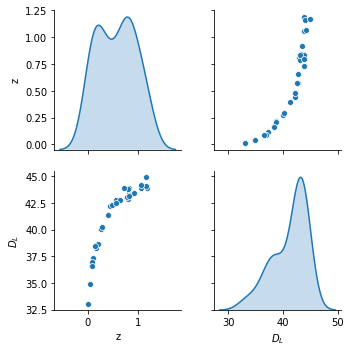

In [69]:
fake_datadf2 = pd.DataFrame(fake_data2, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf2, diag_kind="kde")
# plt.savefig('fake_binned_jla22DO.png')

In [70]:
clean_img = autoencoder2.predict(prediction_mc_dropout_dec[0, :].reshape(1,-1))

In [24]:
# np.savetxt("fake_binned_JLA_COVdecodedDO.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")
# 